In [ ]:
# This notebook performs a statistical analysis of mice doing the cloud of tones task
# stimulating the dopamine release in the tail of the striatum

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install mouse-behavior-analysis-tools
%cd APE_paper/docs/figures_notebooks

In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import exists
import urllib.request
import matplotlib.pylab as plt
import warnings
from ast import literal_eval
from math import e
import seaborn as sns
from scipy import stats

from mouse_behavior_analysis_tools.utils import custom_functions as cuf
from mouse_behavior_analysis_tools.utils.misc_utils import update_progress
from mouse_behavior_analysis_tools.plot import make_figures
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# download data from server
dataset_name = 'DA-optostimulation_dataframe.csv'
url = "https://zenodo.org/record/7261639/files/" + dataset_name
dataset_path = '../../data/' + dataset_name
# download if data is not there
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('Data already in directory')
# load
dao_df = pd.read_csv(dataset_path, index_col=0)

Data already in directory


In [3]:
# reconvert column to a diccionary
dao_df['FullGUI'] = [literal_eval(x) for x in dao_df.FullGUI]

In [4]:
# Select how to group trial numbers to compare
ini_trials = 150 # initial trials without stimulation
ao_trials = 151 # trials without stimulation, after some sampling

In [5]:
def get_dopamine_optostimulation_differences_dataframe(
    dao_df, ini_trials, ao_trials, n_times
):
    # Generate another dataset for every session containing information
    # about the difference between
    # the optostimulated trials and the normal ones,
    # as well as random differences, calculated
    # shuffling the trial indexes
    BRS = ["tStr", "NAc"]
    PS = ["Left", "Right"]
    PI = ["Center", "Side"]
    CondList = [
        (dao_df["TrialIndex"] < ini_trials),
        (dao_df["TrialIndex"] > ao_trials),
    ]

    cols = [
        "AnimalID",
        "SessionID",
        "Ntrials",
        "Protocol",
        "Stim",
        "FiberSide",
        "FiberArea",
        "StimSide",
        "StimPort",
        "Contralateral",
        "InitialBias",
        "Bias",
        "BiasToStimPort",
        "RandomBiases",
        "RandomBiasMean",
        "RandomBiasStd",
        "bias_to_stim_port_cong",
        "bias_to_stim_port_incong",
    ]
    data = np.empty(
        [len(pd.unique(dao_df["SessionID"])), len(cols)], dtype=object
    )

    for i, sessionid in enumerate(pd.unique(dao_df["SessionID"])):
        # get dataframe of the session
        session_df = dao_df[dao_df["SessionID"] == sessionid].copy()
        # get animal name
        animalid = session_df.AnimalID.unique()[0]
        # get number of trials
        ntrials = session_df.shape[0]
        # protocol
        protocol = session_df.Protocol.unique()[0]
        # is it a stimulated session?
        stim = session_df.Stimulation.unique()[0] != "NoStimulation"
        # which fiber was plugged in
        fiberside = session_df.Stimulation.unique()[0]
        # which brain area is this fiber over
        fiberarea = BRS[int(session_df.iloc[0].FullGUI["FiberLocation"]) - 1]
        # which one of the side ports, or trial type, was stimulated
        stimside = PS[int(session_df.iloc[0].FullGUI["JOPSide"]) - 1]
        # in which one of the ports did stimulation occurred
        stimport = PI[int(session_df.iloc[0].FullGUI["OptoState"]) - 1]
        # is the fiber contralateral to the port
        contralateral = True
        if (fiberside == stimside) or fiberside == "Both":
            contralateral = False
        # what is the initial bias of the mouse in trials before stimulation
        ini_sess = session_df[session_df.TrialIndex < ini_trials].copy()
        initialbias = np.mean(
            cuf.get_choices(ini_sess["FirstPoke"], ini_sess["TrialHighPerc"])[1]
        )

        # what is the total bias of that session after opto
        bias = cuf.get_general_right_bias(
            session_df[CondList[1]], session_df[CondList[0]]
        )
        # is this bias positive towards the stimulated port?
        if stimside == "Right":
            biastostimport = bias
        if stimside == "Left":
            biastostimport = -bias

        # make a distinction here about the left trials the right trials
        df_left = session_df[session_df.TrialSide == 1]
        df_right = session_df[session_df.TrialSide == 2]

        bias_of_left = cuf.get_general_right_bias(
            df_left[CondList[1]], df_left[CondList[0]]
        )
        bias_of_right = cuf.get_general_right_bias(
            df_right[CondList[1]], df_right[CondList[0]]
        )
        # define bias to stim port
        if stimside == "Right":
            bias_to_stim_port_incong = bias_of_left
            bias_to_stim_port_cong = bias_of_right
        if stimside == "Left":
            bias_to_stim_port_cong = -bias_of_left
            bias_to_stim_port_incong = -bias_of_right

        # calculate random biases
        randombiases = cuf.get_random_biases(
            session_df, n_times, ini_trials, ao_trials
        )
        # random mean
        randombiasmean = np.mean(randombiases)
        # random std
        randombiasstd = np.std(randombiases)

        # fill
        data[i] = [
            animalid,
            sessionid,
            ntrials,
            protocol,
            stim,
            fiberside,
            fiberarea,
            stimside,
            stimport,
            contralateral,
            initialbias,
            bias,
            biastostimport,
            randombiases,
            randombiasmean,
            randombiasstd,
            bias_to_stim_port_cong,
            bias_to_stim_port_incong,
        ]

        update_progress(i / len(pd.unique(dao_df["SessionID"])))

    # create dataframe
    opto_df = pd.DataFrame(data, columns=cols)
    update_progress(1)

    return opto_df


In [ ]:
# Generate another dataset for every session containing information about the difference between
# the optostimulated trials and the normal ones, as well as random differences, calculated
# shuffling the trial indexes
n_times = 1000 # number of shuffles
opto_df = get_dopamine_optostimulation_differences_dataframe(dao_df, ini_trials,
                                                                 ao_trials, n_times)

 - Progress: [####################] 100.0%


In [7]:
# remove NAc DAopto-03 as the fibers are not correctly placed DV
idx_to_remove = opto_df[np.logical_and(opto_df.AnimalID=='DAopto-03',
                                       opto_df.FiberArea=='NAc')].index

opto_df.drop(idx_to_remove, inplace=True)

In [8]:
# remove tStr DAopto-05 L as the fiber is a bit anterior
idx_to_remove = opto_df[np.logical_and(np.logical_and(opto_df.AnimalID=='DAopto-05',
                                                      opto_df.FiberArea=='tStr'),
                                       opto_df.FiberSide=='Left')].index

opto_df.drop(idx_to_remove, inplace=True)

In [9]:
# Subselect the dataframe based on some conditions
#### conditions
# remove sessions in which initially the mouse is very bias
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# select those sessions for which the stimulation happens in contralateral trials
# this emulates the physiological conditions
conditions = np.logical_and(conditions, opto_df.Contralateral==True)
# select those sessions in which the stimulation happens when the animal is in the cent port
# this tests for state-action associations
conditions = np.logical_and(conditions, opto_df.StimPort=='Center')

opto_df_sel = opto_df[conditions].copy()

In [10]:
def find_indexes_of_repeated_cases(opto_df_sel, same_columns):
    # Find indexes of repeated cases
    equal_indexes = []

    for index in opto_df_sel.index:
        data = opto_df_sel.loc[index][same_columns].values
        i_list = []
        for i in opto_df_sel.index:
            if np.array_equal(data, opto_df_sel.loc[i][same_columns].values):
                i_list.append(i)
        if len(i_list) > 1:
            if i_list not in equal_indexes:
                equal_indexes.append(i_list)

    return equal_indexes

def merge_repeated_cases_for_dopamine_optostimulation(opto_df_sel):

    # Find indexes of repeated cases
    same_columns = [
        "AnimalID",
        "FiberSide",
        "FiberArea",
        "StimSide",
        "StimPort",
    ]
    equal_indexes = find_indexes_of_repeated_cases(opto_df_sel, same_columns)

    # Combine those cases
    for casee in equal_indexes:
        print(casee)
        sub_df = opto_df_sel.loc[casee].copy()
        # create new instance to add to the dataframe,
        # initiating it in the first index of the set
        new_element = sub_df.iloc[0].copy()
        # change relevant values
        new_element.SessionID = "merge"
        new_element.Ntrials = np.mean(sub_df.Ntrials.values)
        new_element.Protocol = "merge"
        new_element.InitialBias = np.nan
        new_element.Bias = np.nan
        new_element.BiasToStimPort = np.mean(sub_df.BiasToStimPort.values)
        new_element.RandomBiases = np.concatenate(sub_df.RandomBiases.values)
        new_element.RandomBiasMean = np.mean(new_element.RandomBiases)
        new_element.RandomBiasStd = np.std(new_element.RandomBiases)
        new_element.bias_to_stim_port_cong = np.mean(sub_df.bias_to_stim_port_cong.values)
        new_element.bias_to_stim_port_incong = np.mean(sub_df.bias_to_stim_port_incong.values)
        # remove old indexes
        opto_df_sel.drop(casee, inplace=True)
        # add new row
        # opto_df_sel = opto_df_sel.append(new_element)
        opto_df_sel = pd.concat([opto_df_sel, pd.DataFrame(new_element).T])
    # opto_df_sel.sort_index(inplace=True)

    return opto_df_sel


In [11]:
# If several sessions exist for one mouse on the same conditions of hemisphere
# and stimulated side, combine them (average results)

opto_df_sel = merge_repeated_cases_for_dopamine_optostimulation(opto_df_sel)

[5, 9]
[6, 8]
[24, 27]
[26, 29]
[45, 49]
[51, 56, 58]
[64, 67]
[73, 75]
[79, 82, 83, 84, 86]
[91, 94]


#### Generate **Figure 4D**

In [12]:
def make_figure_opto_da_boxplots(opto_df_sel, hor):
    dist_to_compare_list = []
    # make a palette
    colors = ["darkslategray", "sandybrown"]

    effect_sizes = []

    # spread of things
    spread = 0.2
    randspread = 2.3 * spread

    # plot
    rel = sns.catplot(
        data=opto_df_sel,
        x="FiberArea",
        y="BiasToStimPort",
        # y="bias_to_stim_port_cong",
        hue="FiberArea",
        alpha=1,
        # size=5,
        marker="o",
        s=10,
        linewidth=1,
        edgecolor="k",  # jitter=.15,
        hue_order=hor,
        kind="swarm",
        height=15,
        aspect=8 / 6,
        palette=sns.color_palette(colors),
    )

    # add the distribution of the random biases, and mean and std
    axs = rel.fig.axes

    orig_y_lim = axs[0].get_ylim()[1]

    # move overall title up
    rel.fig.subplots_adjust(top=0.9)
    rel.fig.suptitle(
        "Contralateral DA stimulation on center port", y=1.05, fontsize=16
    )
    for ax in axs:
        ax.set_ylabel("Bias to stimulated port (% of choices)", fontsize=16)
        ax.set_xlabel("")
        ax.hlines(
            0,
            ax.get_xlim()[0],
            ax.get_xlim()[1],
            linestyles="dotted",
            alpha=0.4,
            zorder=-2,
        )
        for i, pos in enumerate(ax.get_xticks()):
            facond = opto_df_sel.FiberArea == hor[i]
            randbiases = np.array(
                [
                    item
                    for sublist in opto_df_sel[facond].RandomBiases.values
                    for item in sublist
                ]
            )
            bp = ax.boxplot(
                randbiases,
                positions=[pos + randspread],
                widths=0.07,
                patch_artist=True,
                showfliers=False,
            )
            for element in [
                "boxes",
                "whiskers",
                "fliers",
                "means",
                "medians",
                "caps",
            ]:
                plt.setp(bp[element], color="gray", linewidth=3)
            for patch in bp["boxes"]:
                patch.set(facecolor="white")

            # mean and std
            dist_to_compare = opto_df_sel[facond].BiasToStimPort.values
            # dist_to_compare = opto_df_sel[facond].bias_to_stim_port_cong.values
            bp = ax.boxplot(
                dist_to_compare,
                positions=[pos + spread],
                widths=0.07,
                patch_artist=True,
                showfliers=False,
            )
            for element in [
                "boxes",
                "whiskers",
                "fliers",
                "means",
                "medians",
                "caps",
            ]:
                plt.setp(bp[element], color=colors[i], linewidth=3)
            for patch in bp["boxes"]:
                patch.set(facecolor="white")

            pval = stats.ranksums(
                dist_to_compare, randbiases, alternative="greater"
            ).pvalue
            # effect size
            effect_sizes.append((np.mean(dist_to_compare)) / np.std(
                randbiases
            ))
            dist_to_compare_list.append(dist_to_compare)

            ax.text(
                x=i + 1.5 * spread,
                y=1.2 * orig_y_lim,
                s="pval = {:.6}".format(str(pval)),
                horizontalalignment="center",
                fontsize=14,
            )
            ax.plot(
                [i + spread * 0.5, i + randspread],
                [orig_y_lim * 1.1, orig_y_lim * 1.1],
                color="k",
                linewidth=0.5,
            )
            ax.plot(
                [i + spread * 0.5, i + 0.5 * spread],
                [orig_y_lim, orig_y_lim * 1.1],
                color="k",
                linewidth=0.5,
            )
            ax.plot(
                [i + randspread, i + randspread],
                [orig_y_lim, orig_y_lim * 1.1],
                color="k",
                linewidth=0.5,
            )

        ax.set_xlim([-2 * spread, 1 + 5 * spread])
        ax.set_xticks([spread, 1 + spread])

        # for tick in ax.xaxis.get_major_ticks():
        #     tick.label.set_fontsize(16)
        # for tick in ax.yaxis.get_major_ticks():
        #     tick.label.set_fontsize(14)

        # keep only y axis and floating x ticks
        ax.set_frame_on(False)
        xmin, xmax = ax.get_xaxis().get_view_interval()
        ax.plot((xmin, xmin), (-30, 30), color="black", linewidth=1)

        ax.set_xticklabels(hor)

    return rel, effect_sizes, dist_to_compare_list


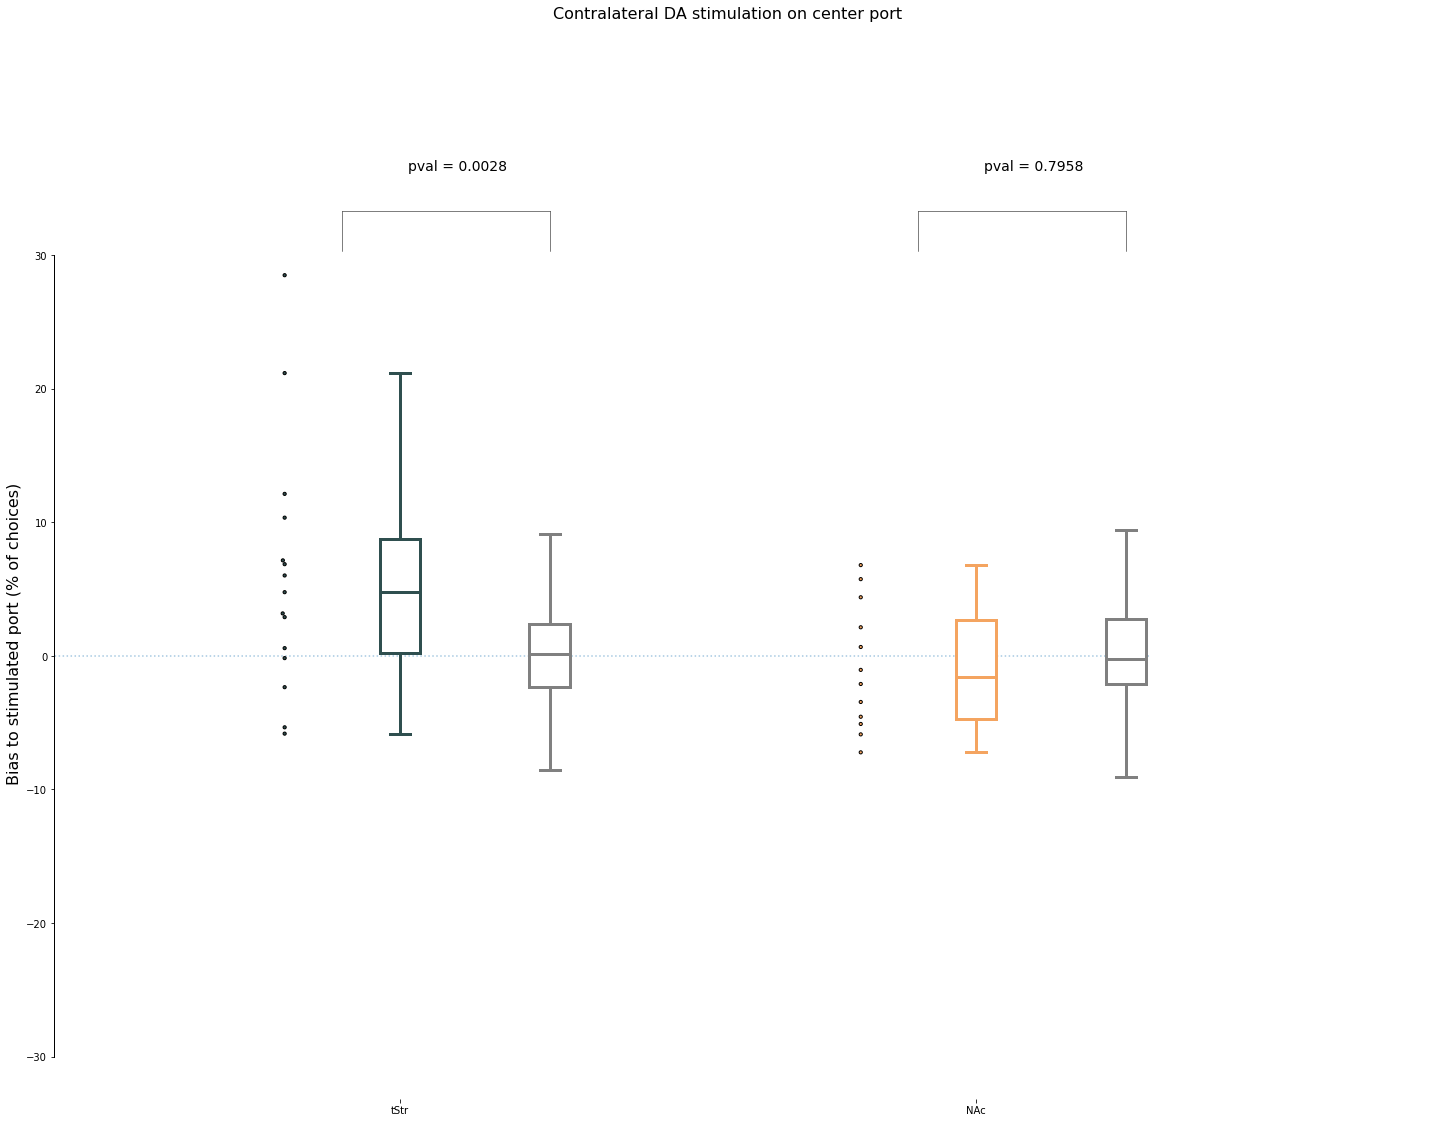

In [15]:
fig, es, dtc = make_figure_opto_da_boxplots(opto_df_sel, hor = ['tStr', 'NAc'])
                                                # tit='Contralateral DA stimulation on center port')
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# fig.savefig('dopamine_optostimulation_centerport_incongruent.pdf',
#             transparent=True, bbox_inches='tight')

In [16]:
w_p = stats.wilcoxon(list(dtc[0])).pvalue
print(f"wilcoxon to zero pval = {w_p}")


wilcoxon to zero pval = 0.01806640625


#### Generate **Figure 4F**

In [16]:
# Subselect the dataframe based on some conditions
#### conditions
# remove sessions in which initially the mouse is very bias
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# select those sessions for which the stimulation is not labeled as contralateral
# as the stimulation was bilateral
conditions = np.logical_and(conditions, opto_df.Contralateral==False)
# select those sessions in which the stimulation happens when the animal is in the cent port
# this tests for state-action associations
conditions = np.logical_and(conditions, opto_df.StimPort=='Side')
# conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')

opto_df_sideport = opto_df[conditions].copy()

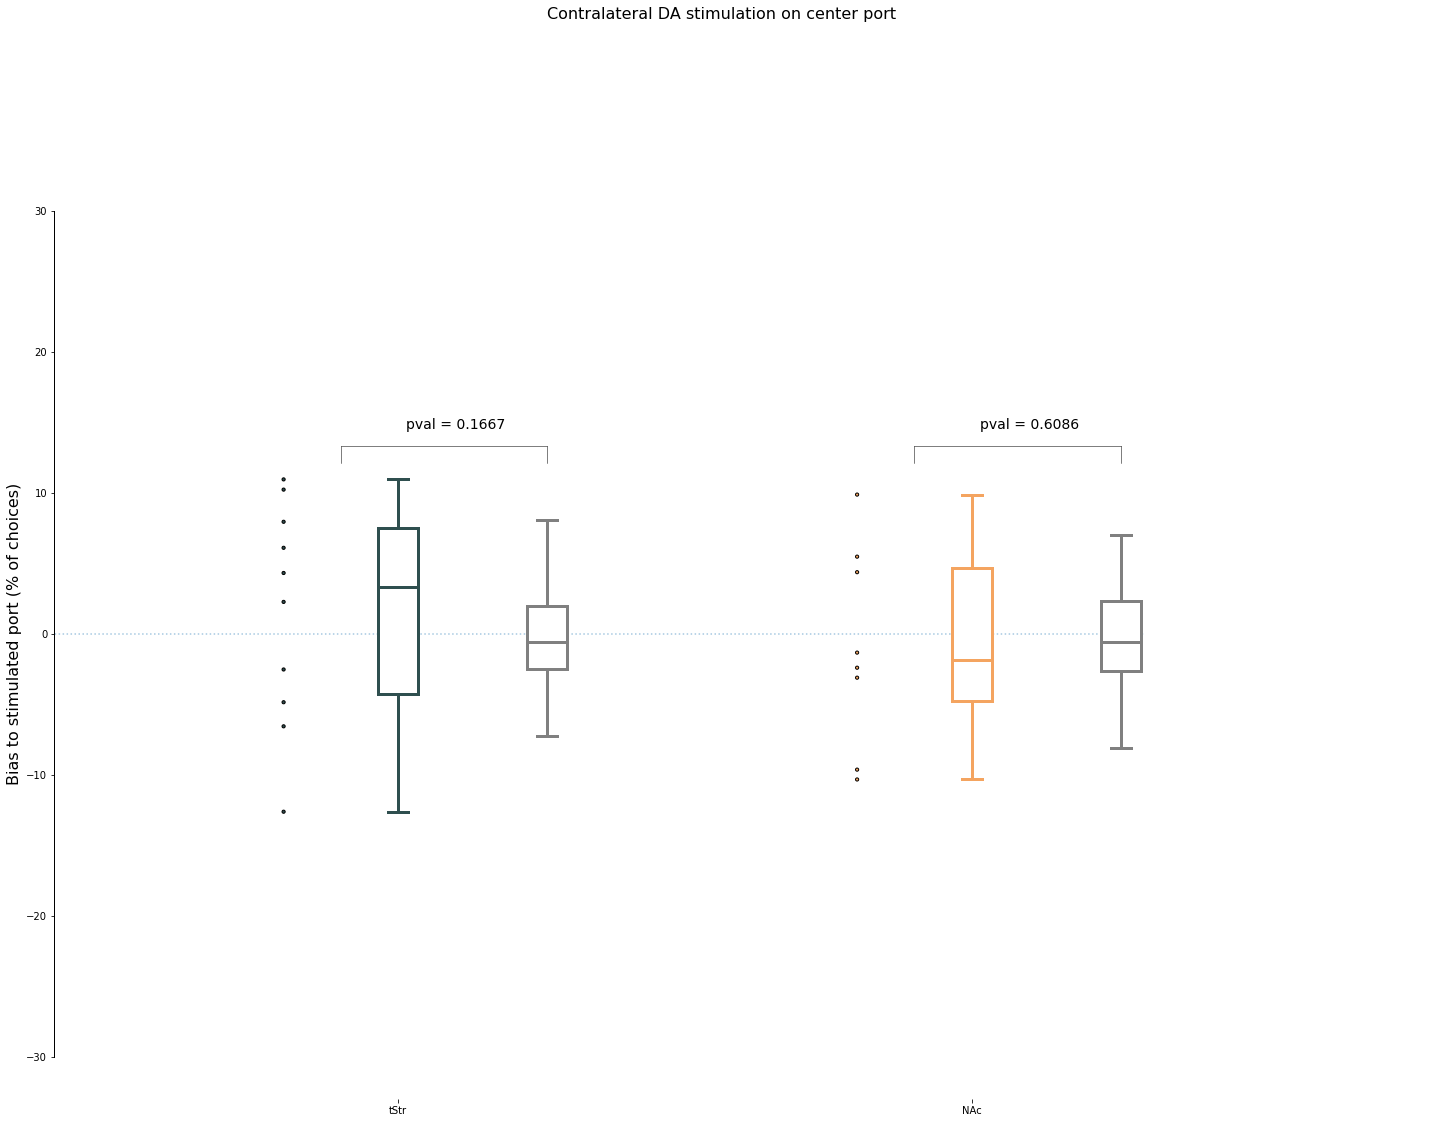

In [ ]:
fig, es2, dtc = make_figure_opto_da_boxplots(opto_df_sideport, hor = ['tStr', 'NAc'])
                                                # tit='Bilateral tStr-DA stimulation\non side port')
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# fig.savefig('dopamine_optostimulation_sideport.pdf',
#             transparent=True, bbox_inches='tight')

In [40]:
w_p = stats.wilcoxon(list(dtc[1])).pvalue
print(f"wilcoxon to zero pval = {w_p}")

wilcoxon to zero pval = 0.84375
